### Capstone Project - PGP BDML
#### Exploratory Data Analysis of Super Market Data
#### Teams: Yagnaraman M, Sathiyakailash S, Rajesh Shankar, Vidya K, Laxman.

In [1]:
import pandas as pd
import numpy as np
import datetime

from pyspark.sql import  SparkSession
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark import SQLContext
import matplotlib.pyplot as plt

from pyspark.sql.functions import col, countDistinct
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import year, month, dayofmonth

import matplotlib as plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sc = SparkContext()

In [3]:
sqlContext = SQLContext(sc)

### Exploratory Data Analysis for Store 44 - Item Data 

In [4]:
item_data = sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/items_store44_2013_2015.csv",header = True,inferSchema = True)

In [5]:
item_data.count()

3104

In [6]:
item_data.show(5)

+--------+------------+-----+----------+
|item_nbr|      family|class|perishable|
+--------+------------+-----+----------+
|  169028|   GROCERY I| 1040|         0|
|  269084|BREAD/BAKERY| 2720|         1|
|  368628|   BEVERAGES| 1122|         0|
|  517909|        DELI| 2690|         1|
|  587069|   GROCERY I| 1004|         0|
+--------+------------+-----+----------+
only showing top 5 rows



In [7]:
item_data.agg(countDistinct("family")).show()

+----------------------+
|count(DISTINCT family)|
+----------------------+
|                    31|
+----------------------+



##### There are 31 family types

In [8]:
item_data.select([count(when(col(c).isNull(), c)).alias(c) for c in item_data.columns]).show()

+--------+------+-----+----------+
|item_nbr|family|class|perishable|
+--------+------+-----+----------+
|       0|     0|    0|         0|
+--------+------+-----+----------+



In [13]:
item_data.describe().show()

+-------+------------------+----------+------------------+------------------+
|summary|          item_nbr|    family|             class|        perishable|
+-------+------------------+----------+------------------+------------------+
|  count|              3104|      3104|              3104|              3104|
|   mean|1106774.6211340206|      null| 2209.420425257732|0.2503221649484536|
| stddev| 526905.2388895251|      null|1497.7548181989923|0.4332683417434914|
|    min|             96995|AUTOMOTIVE|              1002|                 0|
|    max|           2037487|   SEAFOOD|              7780|                 1|
+-------+------------------+----------+------------------+------------------+



#### There are no null values to fix in this file. 

In [9]:
family_count = item_data.groupBy("family").count().sort("count", ascending = False).take(5)
family_count = pd.DataFrame(family_count, columns = ['family', 'count'])

/usr/local/anaconda/python2/lib/python2.7/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


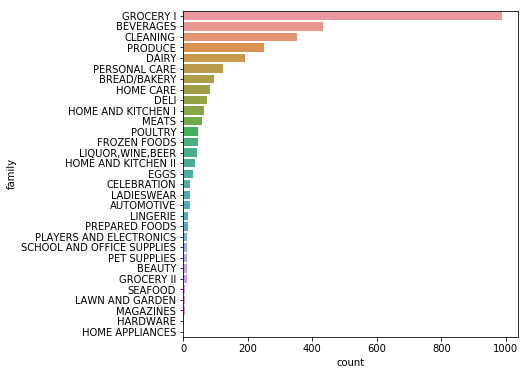

In [10]:
plt.figure(figsize=(6,6))
sns.countplot(y="family",data=item_data.toPandas(),order = item_data.toPandas()['family'].value_counts().index)
plt.show()

#### Grocery I is having most items with almost 900+ items.

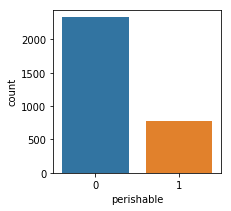

In [11]:
plt.figure(figsize=(3,3))
sns.countplot(x="perishable",data=item_data.toPandas(),order = item_data.toPandas()['perishable'].value_counts().index)
plt.show()

#### The non pershable items are more than the perishable items

### Exploratory Data Analysis for Store 44 - Oil Data

In [12]:
oil_data = sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/oil_2013_2015.csv",header = True,inferSchema = True)

In [13]:
oil_data.count()

783

In [14]:
oil_data.filter("dcoilwtico is NULL").count()

27

In [15]:
oil_data.filter("dcoilwtico is NULL").show(5)

+-------------------+----------+
|               date|dcoilwtico|
+-------------------+----------+
|2013-01-01 00:00:00|      null|
|2013-01-21 00:00:00|      null|
|2013-02-18 00:00:00|      null|
|2013-03-29 00:00:00|      null|
|2013-05-27 00:00:00|      null|
+-------------------+----------+
only showing top 5 rows



##### There are 27 entries where the oil data is not available. Either this should be imputed or needs to be removed.

In [16]:
oil_data.createOrReplaceTempView("oildata")
sqlContext.sql("select year(date), percentile_approx(dcoilwtico, 0.5) from oildata group by year(date)").show()

+------------------------+---------------------------------------------------------+
|year(CAST(date AS DATE))|percentile_approx(dcoilwtico, CAST(0.5 AS DOUBLE), 10000)|
+------------------------+---------------------------------------------------------+
|                    2015|                                                    47.86|
|                    2013|                                                    96.29|
|                    2014|                                                    97.84|
+------------------------+---------------------------------------------------------+



#### Surpirising that Year 2015 has a median of 47.86 though the other two years has relatively higher value. Cross verified the data for Year 2016 and 2017 and it seems to be correct one. 

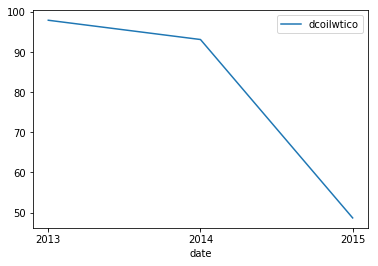

In [17]:
# what is the mean oil price per month starting 2013/01/1 to 2015/12/31
oil_data_pd = oil_data.toPandas()
oil_data_pd['date'] = pd.to_datetime(oil_data_pd['date'])
oil_data_pd.index = oil_data_pd['date']
oil_data_pd.resample('Y').mean().plot()

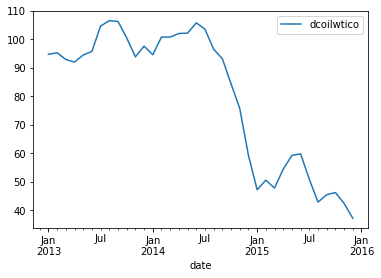

In [18]:
oil_data_pd.resample('M').mean().plot()


### Exploratory Data Analysis for Store 44 - Holiday Events

In [19]:
holiday_data = sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/holidays_events_2013_2015.csv",header = True,inferSchema = True)

In [20]:
holiday_data.count()

170

In [21]:
holiday_data.show()

+-------------------+----------+--------+-----------+--------------------+-----------+
|               date|      type|  locale|locale_name|         description|transferred|
+-------------------+----------+--------+-----------+--------------------+-----------+
|2013-01-01 00:00:00|   Holiday|National|    Ecuador|  Primer dia del ano|      false|
|2013-01-05 00:00:00|  Work Day|National|    Ecuador|Recupero puente N...|      false|
|2013-01-12 00:00:00|  Work Day|National|    Ecuador|Recupero puente p...|      false|
|2013-02-11 00:00:00|   Holiday|National|    Ecuador|            Carnaval|      false|
|2013-02-12 00:00:00|   Holiday|National|    Ecuador|            Carnaval|      false|
|2013-03-02 00:00:00|   Holiday|   Local|      Manta|  Fundacion de Manta|      false|
|2013-04-01 00:00:00|   Holiday|Regional|   Cotopaxi|Provincializacion...|      false|
|2013-04-12 00:00:00|   Holiday|   Local|     Cuenca| Fundacion de Cuenca|      false|
|2013-04-14 00:00:00|   Holiday|   Local|  

In [22]:
holiday_data.groupBy('transferred').count().show()

+-----------+-----+
|transferred|count|
+-----------+-----+
|       true|    2|
|      false|  168|
+-----------+-----+



#### Out of 211 days, there are 3 holidays got transferred to another date. Since the holidays are transferred to the next day it is believed it doesnt impact much of the monthly sales prediction.

In [23]:
holiday_data.filter(col('transferred') == True).show()

+-------------------+-------+--------+-----------+--------------------+-----------+
|               date|   type|  locale|locale_name|         description|transferred|
+-------------------+-------+--------+-----------+--------------------+-----------+
|2013-10-09 00:00:00|Holiday|National|    Ecuador|Independencia de ...|       true|
|2014-10-09 00:00:00|Holiday|National|    Ecuador|Independencia de ...|       true|
+-------------------+-------+--------+-----------+--------------------+-----------+



In [24]:
holiday_year_count = holiday_data.groupBy(year(col('date')), col('type')).count().show()

+----------+----------+-----+
|year(date)|      type|count|
+----------+----------+-----+
|      2013|Additional|    9|
|      2013|     Event|    1|
|      2013|   Holiday|   38|
|      2014|    Bridge|    1|
|      2015|    Bridge|    1|
|      2015|     Event|    3|
|      2014|   Holiday|   38|
|      2014|Additional|    9|
|      2015|  Work Day|    1|
|      2014|  Transfer|    1|
|      2015|Additional|    8|
|      2014|  Work Day|    1|
|      2015|   Holiday|   39|
|      2013|  Transfer|    1|
|      2013|  Work Day|    2|
|      2014|     Event|   17|
+----------+----------+-----+



/usr/local/anaconda/python2/lib/python2.7/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


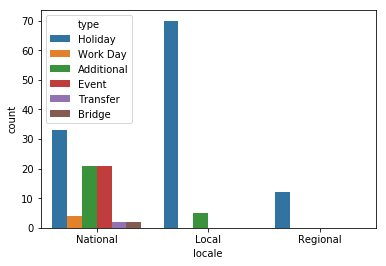

In [25]:
sns.countplot(x="locale",hue="type",data=holiday_data.toPandas())
plt.show()

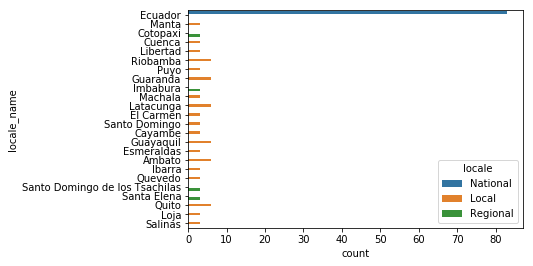

In [26]:
sns.countplot(y="locale_name",hue="locale",data=holiday_data.toPandas())
plt.show()

/usr/local/anaconda/python2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  This is separate from the ipykernel package so we can avoid doing imports until


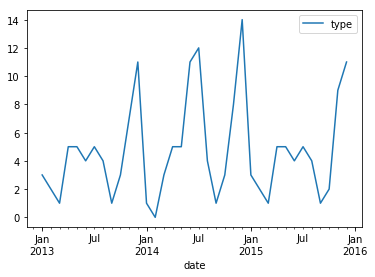

In [27]:
holiday_data_pd = holiday_data.toPandas()
holiday_data_pd.index = holiday_data_pd['date']
holiday_data_pd.resample('M',how={'type':'count'}).plot()
plt.show()

#### It is observed that the holiday count is higher around Nov and Dec region.

### Exploratory Data Analysis for Store 44 - Transaction Data 

In [28]:
transaction_data = sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/transactions_store44.csv",header = True,inferSchema = True)

In [68]:
transaction_data.count()

1089

In [29]:
transaction_data.show(10)

+-------------------+---------+------------+
|               date|store_nbr|transactions|
+-------------------+---------+------------+
|2013-01-02 00:00:00|       44|        4821|
|2013-01-03 00:00:00|       44|        3618|
|2013-01-04 00:00:00|       44|        4169|
|2013-01-05 00:00:00|       44|        4921|
|2013-01-06 00:00:00|       44|        4925|
|2013-01-07 00:00:00|       44|        3871|
|2013-01-08 00:00:00|       44|        3593|
|2013-01-09 00:00:00|       44|        4006|
|2013-01-10 00:00:00|       44|        3323|
|2013-01-11 00:00:00|       44|        3873|
+-------------------+---------+------------+
only showing top 10 rows



In [30]:
transaction_data.select([count(when(col(c).isNull(), c)).alias(c) for c in transaction_data.columns]).show()

+----+---------+------------+
|date|store_nbr|transactions|
+----+---------+------------+
|   0|        0|           0|
+----+---------+------------+



#### No Null values in the transaction data

In [31]:
transaction_data.select("store_nbr").distinct().show()

+---------+
|store_nbr|
+---------+
|       44|
+---------+



#### We have used only Store 44 for the Analysis

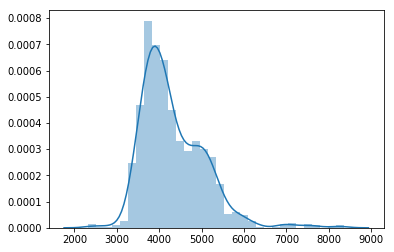

In [32]:
trans = transaction_data.select("transactions").collect()
sns.distplot(trans)

In [33]:
minRow = transaction_data.agg({"date": "min"}).collect()[0]
print minRow["min(date)"]

2013-01-02 00:00:00


In [34]:
maxRow = transaction_data.agg({"date": "max"}).collect()[0]
print maxRow["max(date)"]

2015-12-31 00:00:00


#### Transaction data of years 2013 to 2015 is taken for analysis

In [35]:
transaction_data_pd = transaction_data.toPandas()
transaction_data_pd['date'] = pd.to_datetime(transaction_data_pd['date'])
transaction_data_pd.index = transaction_data_pd['date']

/usr/local/anaconda/python2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  


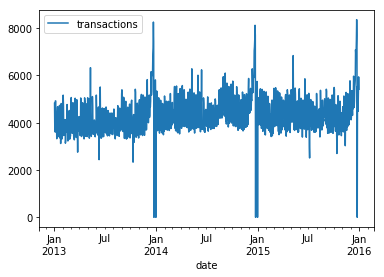

In [36]:
plt.figure(figsize=(7,9))
transaction_data_pd.resample('D',how={'transactions':'sum'}).plot()
plt.show()

/usr/local/anaconda/python2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  """Entry point for launching an IPython kernel.


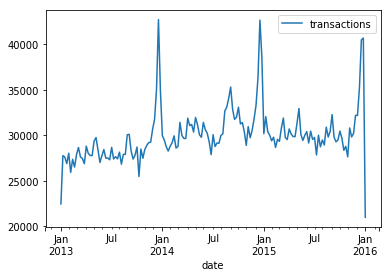

In [37]:
transaction_data_pd.resample('W',how={'transactions':'sum'}).plot()
plt.show()

In [38]:
#### Let us take Transactions of each year
Transactions2013 = transaction_data_pd['2013'].groupby('store_nbr').resample('Y',how={'transactions':'sum'})
Transactions2014 = transaction_data_pd['2014'].groupby('store_nbr').resample('Y',how={'transactions':'sum'})
Transactions2015 = transaction_data_pd['2015'].groupby('store_nbr').resample('Y',how={'transactions':'sum'})

/usr/local/anaconda/python2/lib/python2.7/site-packages/pandas/core/groupby.py:1324: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  return get_resampler_for_grouping(self, rule, *args, **kwargs)


In [39]:
Transactions2013.sort_values('transactions',ascending=False)

,,transactions
store_nbr,date,
44,2013-12-31,1493932


In [40]:
Transactions2014.sort_values('transactions',ascending=False)

,,transactions
store_nbr,date,
44,2014-12-31,1622607


In [41]:
Transactions2015.sort_values('transactions',ascending=False)

,,transactions
store_nbr,date,
44,2015-12-31,1593523


### Exploratory Data Analysis for Store 44 - Train Data 

In [42]:
train_data = sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/train_store44.csv",header = True,inferSchema = True)

In [43]:
train_data.show(5)

+-----+-------------------+---------+--------+----------+-----------+
|   id|               date|store_nbr|item_nbr|unit_sales|onpromotion|
+-----+-------------------+---------+--------+----------+-----------+
|32292|2013-01-02 00:00:00|       44|  103520|      12.0|       null|
|32293|2013-01-02 00:00:00|       44|  103665|      20.0|       null|
|32294|2013-01-02 00:00:00|       44|  105574|      51.0|       null|
|32295|2013-01-02 00:00:00|       44|  105575|      74.0|       null|
|32296|2013-01-02 00:00:00|       44|  105577|      23.0|       null|
+-----+-------------------+---------+--------+----------+-----------+
only showing top 5 rows



In [44]:
train_data.select("id").distinct().count()

1913387

In [45]:
#### There are close to 2 M records for which the ID can act as primary key/one of the primary keys

In [46]:
train_data.select([count(when(col(c).isNull(), c)).alias(c) for c in train_data.columns]).show()

+---+----+---------+--------+----------+-----------+
| id|date|store_nbr|item_nbr|unit_sales|onpromotion|
+---+----+---------+--------+----------+-----------+
|  0|   0|        0|       0|         0|     649721|
+---+----+---------+--------+----------+-----------+



In [47]:
train_data.select("onpromotion").distinct().show()

+-----------+
|onpromotion|
+-----------+
|       null|
|       true|
|      false|
+-----------+



In [48]:
# There are few null values in the on promotion flag.

In [49]:
train_data.describe().show()

+-------+--------------------+--------------------+-----------------+-----------------+
|summary|                  id|           store_nbr|         item_nbr|       unit_sales|
+-------+--------------------+--------------------+-----------------+-----------------+
|  count|             1913387|             1913387|          1913387|          1913387|
|   mean|3.2444040060134202E7|                44.0|847920.4138692277|18.41339533173389|
| stddev| 1.909390693754702E7|3.221893743654590...|439503.7729726517|41.98475192015884|
|    min|               32292|                  44|            96995|          -1806.0|
|    max|            66439180|                  44|          2037487|           8009.0|
+-------+--------------------+--------------------+-----------------+-----------------+



In [50]:
### Unit Sales in negative? need to explore further

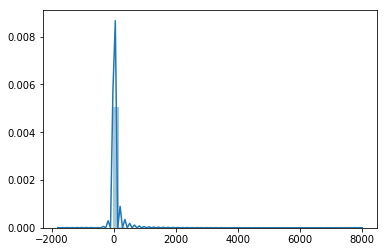

In [51]:
unit_sales = train_data.select("unit_sales").collect()
sns.distplot(unit_sales)

In [52]:
train_data.filter(col("unit_sales") < 0 ).count()

204

##### There are 204 such columns having negative unit count. There are return items which has caused the negative value. Let us find out most returned item

In [53]:
train_data.filter(col("unit_sales") < 0 ).sort(col('unit_sales') , ascending = True).show(5)

+--------+-------------------+---------+--------+----------+-----------+
|      id|               date|store_nbr|item_nbr|unit_sales|onpromotion|
+--------+-------------------+---------+--------+----------+-----------+
|64987178|2015-12-15 00:00:00|       44|  257847|   -1806.0|      false|
|64988339|2015-12-15 00:00:00|       44| 1157564|     -75.0|      false|
|50915572|2015-07-08 00:00:00|       44|  819934|     -62.0|      false|
|50915631|2015-07-08 00:00:00|       44|  847859|     -61.0|      false|
| 6831152|2013-06-11 00:00:00|       44|  318847|     -41.0|       null|
+--------+-------------------+---------+--------+----------+-----------+
only showing top 5 rows



In [54]:
item_data.filter(col('item_nbr') == 257847).show()

+--------+---------+-----+----------+
|item_nbr|   family|class|perishable|
+--------+---------+-----+----------+
|  257847|BEVERAGES| 1120|         0|
+--------+---------+-----+----------+



#### Beverages has cost the maximum return among the unit sales.

In [55]:
sqlContext.registerDataFrameAsTable(train_data, "traintbl")
train_2013 = sqlContext.sql("select *  from traintbl where date < '2014-01-01 00:00:00'")
train_2013.describe().show()

+-------+------------------+---------+-----------------+------------------+
|summary|                id|store_nbr|         item_nbr|        unit_sales|
+-------+------------------+---------+-----------------+------------------+
|  count|            490565|   490565|           490565|            490565|
|   mean| 8147906.823854127|     44.0|667409.3862750095|16.974961517841624|
| stddev|4721717.3137169825|      0.0|324248.2978496713| 42.44433576403105|
|    min|             32292|       44|            96995|             -41.0|
|    max|          16312338|       44|          1247036|            6010.0|
+-------+------------------+---------+-----------------+------------------+



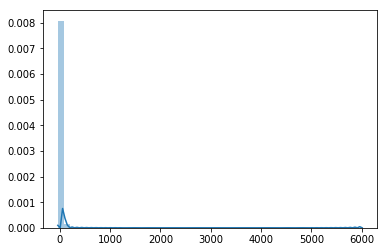

In [56]:
unit_sales_2013 = train_2013.select("unit_sales").collect()
sns.distplot(unit_sales_2013)
plt.show()

In [57]:
train_2014 = sqlContext.sql("select *  from traintbl where date >= '2014-01-01 00:00:00' and date < '2015-01-01 00:00:00'")
train_2014.describe().show()

+-------+-------------------+---------+------------------+-----------------+
|summary|                 id|store_nbr|          item_nbr|       unit_sales|
+-------+-------------------+---------+------------------+-----------------+
|  count|             657633|   657633|            657633|           657633|
|   mean|2.739485696412893E7|     44.0| 863517.4424306566|20.34601231173009|
| stddev|  6418209.431418302|      0.0|431977.87520716176|45.28781190365764|
|    min|           16375625|       44|             96995|            -36.0|
|    max|           38577787|       44|           1909770|         6025.771|
+-------+-------------------+---------+------------------+-----------------+



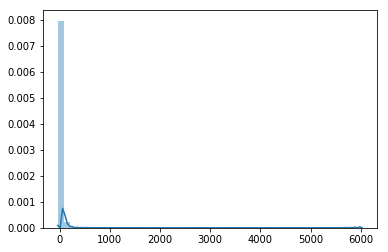

In [58]:
unit_sales_2014 = train_2014.select("unit_sales").collect()
sns.distplot(unit_sales_2014)
plt.show()

In [59]:
train_2015 = sqlContext.sql("select *  from traintbl where date >= '2015-01-01 00:00:00' and date < '2016-01-01 00:00:00'")
train_2015.describe().show()

+-------+-------------------+---------+------------------+-----------------+
|summary|                 id|store_nbr|          item_nbr|       unit_sales|
+-------+-------------------+---------+------------------+-----------------+
|  count|             765189|   765189|            765189|           765189|
|   mean|5.235982822231501E7|     44.0| 950241.8946639327|17.67461390845924|
| stddev|  8059168.696894901|      0.0|472933.70585664443| 38.5359330510908|
|    min|           38641037|       44|             99197|          -1806.0|
|    max|           66439180|       44|           2037487|           8009.0|
+-------+-------------------+---------+------------------+-----------------+



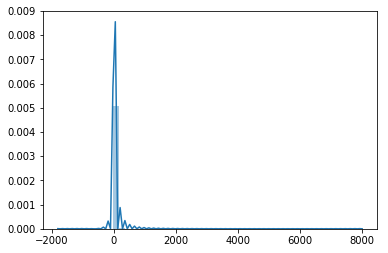

In [60]:
unit_sales_2015 = train_2015.select("unit_sales").collect()
sns.distplot(unit_sales_2015)
plt.show()

In [61]:
# There there is outlier for unit sales because of the returns

In [62]:
trainTbl2013 = sqlContext.sql("SELECT store_nbr as store_nbr,year(date) as date,count(item_nbr) as count_item_nbr,(sum(unit_sales)*count(item_nbr)) as total_sales from traintbl where year(date) ='2013' group by store_nbr,year(date)")
trainTbl2013.show()

+---------+----+--------------+--------------------+
|store_nbr|date|count_item_nbr|         total_sales|
+---------+----+--------------+--------------------+
|       44|2013|        490565|4.085092715458293...|
+---------+----+--------------+--------------------+



In [63]:
trainTbl2014 = sqlContext.sql("SELECT store_nbr as store_nbr,year(date) as date,count(item_nbr) as count_item_nbr,(sum(unit_sales)*count(item_nbr)) as total_sales from traintbl where year(date) ='2014' group by store_nbr,year(date)")
trainTbl2014.show()

+---------+----+--------------+--------------------+
|store_nbr|date|count_item_nbr|         total_sales|
+---------+----+--------------+--------------------+
|       44|2014|        657633|8.799267060661738E12|
+---------+----+--------------+--------------------+



In [64]:
trainTbl2015 = sqlContext.sql("SELECT store_nbr as store_nbr,year(date) as date,count(item_nbr) as count_item_nbr,(sum(unit_sales)*count(item_nbr)) as total_sales from traintbl where year(date) ='2015' group by store_nbr,year(date)")
trainTbl2015.show()

+---------+----+--------------+--------------------+
|store_nbr|date|count_item_nbr|         total_sales|
+---------+----+--------------+--------------------+
|       44|2015|        765189|1.034873752403685E13|
+---------+----+--------------+--------------------+



#### The yearly sales has improved over the three years.

In [65]:
item_data.createOrReplaceTempView("vwItems")
train_data.createOrReplaceTempView("vwTrain")

In [66]:
sqlContext.sql('select count(distinct vwTrain.item_nbr)  from vwItems, vwTrain where vwItems.item_nbr = vwTrain.item_nbr').show()

+------------------------+
|count(DISTINCT item_nbr)|
+------------------------+
|                    3104|
+------------------------+



#### train has 3104 items while 4100 items are present in total. Hence there are few items for which there is no data to predict.